In [1]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,#unetr
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    ToTensor,
    ToTensord
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

import logging
logging.disable(logging.WARNING)


import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpvpa19wkg


In [4]:
# num_samples = 4

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-175,
#             a_max=250,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
#         EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(96, 96, 96),
#             pos=1,
#             neg=1,
#             num_samples=num_samples,
#             image_key="image",
#             image_threshold=0,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[0],
#             prob=0.10,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[1],
#             prob=0.10,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[2],
#             prob=0.10,
#         ),
#         RandRotate90d(
#             keys=["image", "label"],
#             prob=0.10,
#             max_k=3,
#         ),
#         RandShiftIntensityd(
#             keys=["image"],
#             offsets=0.10,
#             prob=0.50,
#         ),
#     ]
# )
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
#         EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
#     ]
# )
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [5]:
split_json = "dataset_0.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]


image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


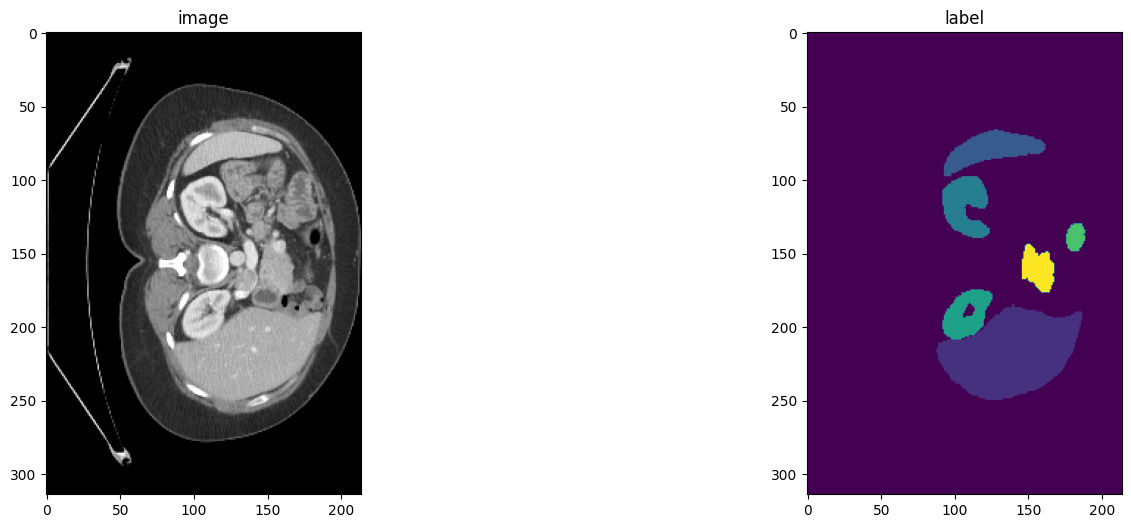

In [6]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [ ]:
# uncomment to download the pre-trained weights
# !wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

In [8]:
weight = torch.load("/home/user/Documents/swin_unetr/model_swinvit.pt")
model.load_from(weights=weight)
print("Using pretrained self-supervied Swin UNETR backbone weights !")

Using pretrained self-supervied Swin UNETR backbone weights !


In [9]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [10]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [11]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Validate (X / X Steps) (dice=X.X):   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Training (500 / 25000 Steps) (loss=1.29340):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 21/24 [00:33<00:17,  5.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.24406559765338898 Current Avg. Dice: 0.24406559765338898


Training (1000 / 25000 Steps) (loss=1.03494):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:30<00:41,  5.86s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5685513615608215 Current Avg. Dice: 0.5685513615608215


Training (1500 / 25000 Steps) (loss=0.84511):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:26<01:04,  5.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7380895614624023 Current Avg. Dice: 0.7380895614624023


Training (2000 / 25000 Steps) (loss=0.77211):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:24<01:31,  6.09s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8187296986579895 Current Avg. Dice: 0.8187296986579895


Training (2500 / 25000 Steps) (loss=0.70023):  21%|█████████████████████████▏                                                                                               | 5/24 [00:20<02:11,  6.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8422344326972961 Current Avg. Dice: 0.8422344326972961


Training (3000 / 25000 Steps) (loss=0.75897):   4%|█████                                                                                                                    | 1/24 [00:17<06:36, 17.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8422344326972961 Current Avg. Dice: 0.835167646408081


Training (3500 / 25000 Steps) (loss=0.70226):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:33<00:17,  5.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.866954505443573 Current Avg. Dice: 0.866954505443573


Training (4000 / 25000 Steps) (loss=0.59810):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:29<00:40,  5.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.866954505443573 Current Avg. Dice: 0.8545084595680237


Training (4500 / 25000 Steps) (loss=0.71711):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:26<01:04,  5.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8674485683441162 Current Avg. Dice: 0.8674485683441162


Training (5000 / 25000 Steps) (loss=0.61076):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:23<01:28,  5.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8674485683441162 Current Avg. Dice: 0.8513612747192383


Training (5500 / 25000 Steps) (loss=0.65267):  21%|█████████████████████████▏                                                                                               | 5/24 [00:20<02:07,  6.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8674485683441162 Current Avg. Dice: 0.8469637036323547


Training (6000 / 25000 Steps) (loss=0.59293):   4%|█████                                                                                                                    | 1/24 [00:17<06:43, 17.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8717462420463562 Current Avg. Dice: 0.8717462420463562


Training (6500 / 25000 Steps) (loss=0.79265):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:32<00:17,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8717462420463562 Current Avg. Dice: 0.8663535118103027


Training (7000 / 25000 Steps) (loss=0.69974):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:29<00:40,  5.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8717462420463562 Current Avg. Dice: 0.8699983954429626


Training (7500 / 25000 Steps) (loss=0.63802):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:26<01:04,  5.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8773309588432312 Current Avg. Dice: 0.8773309588432312


Training (8000 / 25000 Steps) (loss=0.52097):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:23<01:28,  5.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8773309588432312 Current Avg. Dice: 0.866121232509613


Training (8500 / 25000 Steps) (loss=0.65444):  21%|█████████████████████████▏                                                                                               | 5/24 [00:20<02:07,  6.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8773309588432312 Current Avg. Dice: 0.8466154932975769


Training (9000 / 25000 Steps) (loss=0.33778):   4%|█████                                                                                                                    | 1/24 [00:17<06:43, 17.52s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8841531276702881 Current Avg. Dice: 0.8841531276702881


Training (9500 / 25000 Steps) (loss=0.54423):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:32<00:17,  5.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8846213817596436 Current Avg. Dice: 0.8846213817596436


Training (10000 / 25000 Steps) (loss=0.47965):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:39,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8846213817596436 Current Avg. Dice: 0.8768989443778992


Training (10500 / 25000 Steps) (loss=0.55882):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:26<01:03,  5.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8846213817596436 Current Avg. Dice: 0.8753502368927002


Training (11000 / 25000 Steps) (loss=0.45397):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:23<01:28,  5.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8846213817596436 Current Avg. Dice: 0.8751470446586609


Training (11500 / 25000 Steps) (loss=0.67378):  21%|█████████████████████████                                                                                               | 5/24 [00:20<02:07,  6.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8846213817596436 Current Avg. Dice: 0.8684468865394592


Training (12000 / 25000 Steps) (loss=0.61576):   4%|█████                                                                                                                   | 1/24 [00:17<06:37, 17.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8846213817596436 Current Avg. Dice: 0.8790395259857178


Training (12500 / 25000 Steps) (loss=0.38523):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:32<00:17,  5.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.886927604675293 Current Avg. Dice: 0.886927604675293


Training (13000 / 25000 Steps) (loss=0.60692):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:40,  5.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.886927604675293 Current Avg. Dice: 0.8841531872749329


Training (13500 / 25000 Steps) (loss=0.54590):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:26<01:03,  5.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.886927604675293 Current Avg. Dice: 0.8751886487007141


Training (14000 / 25000 Steps) (loss=0.66411):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:23<01:28,  5.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.886927604675293 Current Avg. Dice: 0.8799362182617188


Training (14500 / 25000 Steps) (loss=0.53015):  21%|█████████████████████████                                                                                               | 5/24 [00:20<02:09,  6.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8875536322593689 Current Avg. Dice: 0.8875536322593689


Training (15000 / 25000 Steps) (loss=0.39355):   4%|█████                                                                                                                   | 1/24 [00:17<06:36, 17.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8875536322593689 Current Avg. Dice: 0.8784987330436707


Training (15500 / 25000 Steps) (loss=0.48987):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:32<00:17,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8875536322593689 Current Avg. Dice: 0.8741874694824219


Training (16000 / 25000 Steps) (loss=0.49921):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:40,  5.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8875536322593689 Current Avg. Dice: 0.692659854888916


Training (16500 / 25000 Steps) (loss=0.51297):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:26<01:03,  5.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8875536322593689 Current Avg. Dice: 0.8595048785209656


Training (17000 / 25000 Steps) (loss=0.59310):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:23<01:29,  6.00s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8940108418464661


Training (17500 / 25000 Steps) (loss=0.36686):  21%|█████████████████████████                                                                                               | 5/24 [00:20<02:07,  6.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8803021311759949


Training (18000 / 25000 Steps) (loss=0.69253):   4%|█████                                                                                                                   | 1/24 [00:17<06:37, 17.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8416362404823303


Training (18500 / 25000 Steps) (loss=0.69074):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:32<00:17,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.866579532623291


Training (19000 / 25000 Steps) (loss=0.45297):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:39,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8867091536521912


Training (19500 / 25000 Steps) (loss=0.54947):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:26<01:03,  5.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8787217140197754


Training (20000 / 25000 Steps) (loss=0.39135):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:23<01:28,  5.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.884223461151123


Training (20500 / 25000 Steps) (loss=0.50113):  21%|█████████████████████████                                                                                               | 5/24 [00:20<02:07,  6.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8937652707099915


Training (21000 / 25000 Steps) (loss=0.66998):   4%|█████                                                                                                                   | 1/24 [00:17<06:37, 17.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8886790871620178


Training (21500 / 25000 Steps) (loss=0.58510):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:32<00:17,  5.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8853932023048401


Training (22000 / 25000 Steps) (loss=0.48685):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:39,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8910703659057617


Training (22500 / 25000 Steps) (loss=0.47648):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:26<01:03,  5.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8937798142433167


Training (23000 / 25000 Steps) (loss=0.33121):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:23<01:28,  5.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8940108418464661 Current Avg. Dice: 0.8862664103507996


Training (23500 / 25000 Steps) (loss=0.42989):  21%|█████████████████████████                                                                                               | 5/24 [00:20<02:09,  6.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.894230842590332 Current Avg. Dice: 0.894230842590332


Training (24000 / 25000 Steps) (loss=0.60820):   4%|█████                                                                                                                   | 1/24 [00:17<06:43, 17.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8945345282554626 Current Avg. Dice: 0.8945345282554626


Training (24500 / 25000 Steps) (loss=0.32440):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:32<00:17,  5.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8945345282554626 Current Avg. Dice: 0.8866097331047058


Training (25000 / 25000 Steps) (loss=0.51512):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:40,  5.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8947315216064453 Current Avg. Dice: 0.8947315216064453


Training (25007 / 25000 Steps) (loss=0.43094): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.47s/it]


<All keys matched successfully>

In [12]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8947 at iteration: 25000


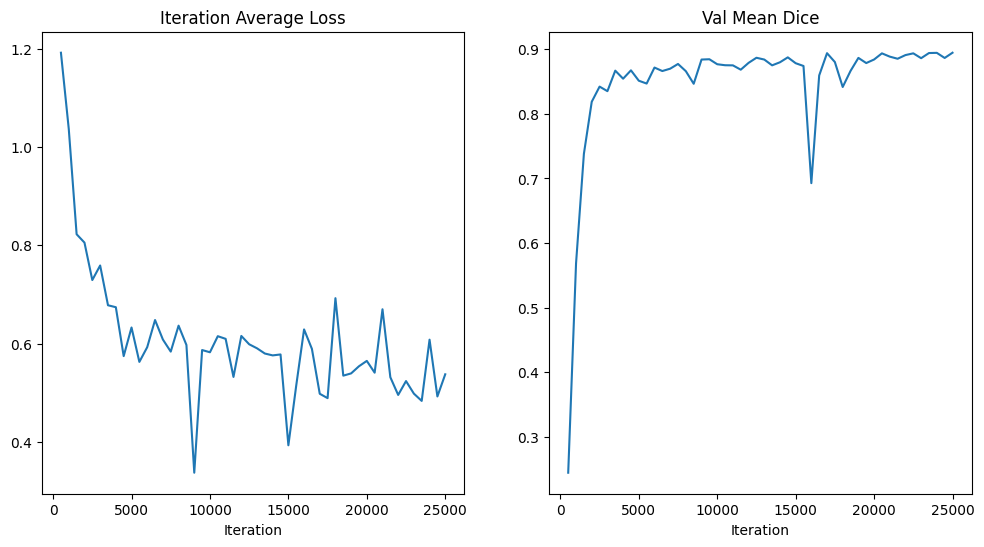

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
#inference on majei

In [7]:
#导入用到得module
import os
import shutil
import numpy as np
import itk
from PIL import Image
import tempfile
from monai.data import ITKReader, PILReader
from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose,Invertd,AsDiscreted, SaveImaged,
)
from monai.handlers.utils import from_engine

from monai.config import print_config

print_config()


MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [8]:
# split_json = "dataset_0.json"
# data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
from monai.inferers import sliding_window_inference
from monai.data import NiftiSaver

device = torch.device("cuda:0")


In [9]:
# data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503/'
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

test_files = load_decathlon_datalist(datasets, True, "validation")

test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="/media/user/2tb/dataset/wordpred/swin_unetr", output_postfix="", resample=False),
    ]
)

# test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_num=114, cache_rate=1.0, num_workers=4)
test_ds = CacheDataset(data=test_files, transform=test_transforms, num_workers=4)
test_loader = ThreadDataLoader(test_ds, num_workers=0, batch_size=1)

# data = transform(img_path).to(device)

Loading dataset: 100%|████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


In [10]:
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [12]:
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1
# with torch.no_grad():
# #     for case_num in range(0,114):
#     img_name = os.path.split(test_ds[case_num]["image"].meta["filename_or_obj"])[1]
#     img = test_ds[case_num]["image"]
#     test_inputs = torch.unsqueeze(img, 1).cuda()
#     test_outputs = sliding_window_inference(test_inputs, (96, 96, 96), 4, model, overlap=0.8,sw_device="cuda")
#     test_outputs=torch.argmax(test_outputs, dim=1)
# #     saver=NiftiSaver(output_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/datasetmajei/swinunetr_majei_output',output_ext=img_name)
#     saver=NiftiSaver(output_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/datasetmajei',output_ext=img_name)
#     saver.save(test_outputs

# with torch.no_grad():
#     for test_data in test_loader:
#         test_inputs = test_data["image"].to(device)
#         test_data["pred"] = sliding_window_inference(test_inputs, (96,96,96), 4, model)

#         test_data = [post_transforms(i) for i in decollate_batch(test_data)]
#         test_output = from_engine(["pred"])(test_data)


with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96,96,96), 4, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)


None of the inputs have requires_grad=True. Gradients will be None


RuntimeError: applying transform <monai.transforms.post.dictionary.Invertd object at 0x7fe93da9c250>

In [ ]:
#inference on word dataset

In [4]:
#导入用到得module
import os
import shutil
import numpy as np
import itk
from PIL import Image
import tempfile
from monai.data import ITKReader, PILReader
from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose,Invertd,AsDiscreted, SaveImaged,
)
from monai.handlers.utils import from_engine

from monai.config import print_config

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
# split_json = "dataset_0.json"
# data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
from monai.inferers import sliding_window_inference
from monai.data import NiftiSaver

device = torch.device("cuda:0")


In [6]:
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [7]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

In [8]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [8]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)


val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=100, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


In [10]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [06:04<00:00,  3.65s/it]

dice_val: 0.7114782929420471


In [11]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [06:04<00:00,  3.64s/it]

dice_val: 0.7104701867103577


In [13]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [06:04<00:00,  3.64s/it]

dice_val: 0.748806893825531


In [11]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [06:04<00:00,  3.65s/it]

dice_val: 0.7214286923408508


In [12]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [06:03<00:00,  3.64s/it]

dice_val: 0.7853967547416687


<class 'dict'>


None of the inputs have requires_grad=True. Gradients will be None


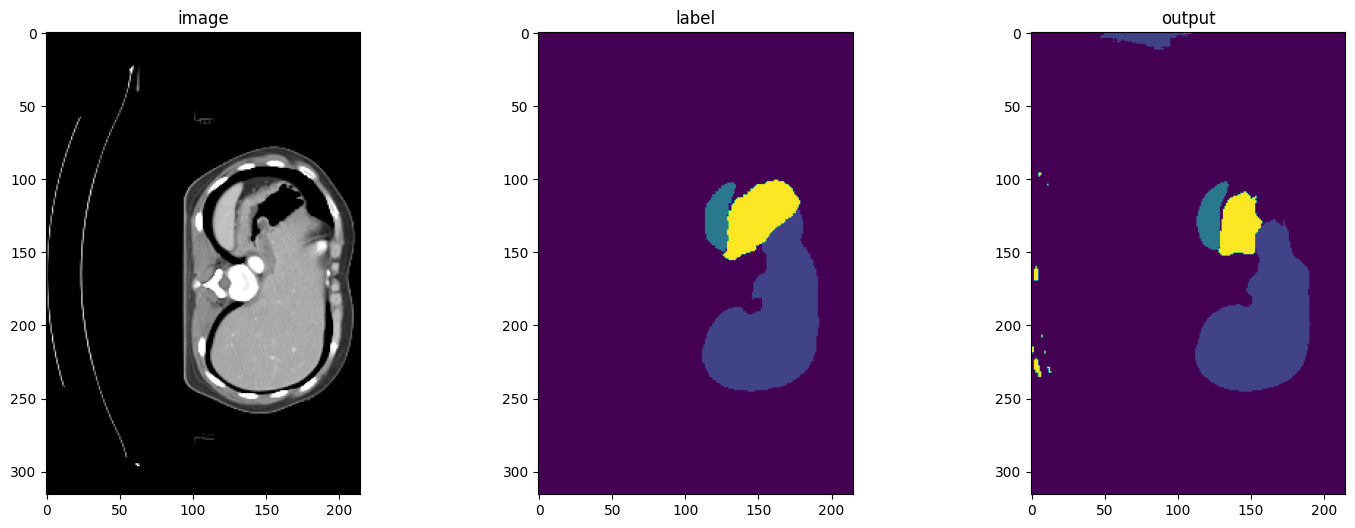

In [7]:
slice_map = {
    "word_0002.nii.gz": 170,
    "word_0003.nii.gz": 230,
    "word_0004.nii.gz": 204,
    "word_0005.nii.gz": 204,
    "word_0006.nii.gz": 204,
    "word_0008.nii.gz": 180,
}
case_num = 1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    print(type(val_ds[case_num]))
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [10]:
#inference MMH
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)


val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=57, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|██████████████████████████| 57/57 [00:19<00:00,  2.98it/s]


In [17]:
#fold0_test
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:57<00:00,  1.01s/it]

dice_val: 0.2730907201766968


In [14]:
#swinunetr inference 
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:57<00:00,  1.01s/it]

dice_val: 0.3559509217739105


In [13]:
#swinunetr inference 
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:57<00:00,  1.02s/it]

dice_val: 0.2785322368144989


In [12]:
#swinunetr inference 
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:57<00:00,  1.01s/it]

dice_val: 0.4045802652835846


In [11]:
#swinunetr inference 
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [01:00<00:00,  1.06s/it]

dice_val: 0.18865294754505157


In [ ]:
#inference MMH updown_flip

In [9]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503_updown_flip/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)


val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=100, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|██████████████████████████| 57/57 [00:19<00:00,  2.92it/s]


In [11]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold0_best_metric_model")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [01:00<00:00,  1.06s/it]

dice_val: 0.23404674232006073


In [12]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:57<00:00,  1.02s/it]

dice_val: 0.32804927229881287


In [17]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:57<00:00,  1.01s/it]

dice_val: 0.2730907201766968


In [13]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:57<00:00,  1.01s/it]

dice_val: 0.3645433187484741


In [14]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:58<00:00,  1.02s/it]

dice_val: 0.19286225736141205
